# Stock Research

In [1]:
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
yf.pdr_override()
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")
pd.core.common.is_list_like = pd.api.types.is_list_like

#### Augmented Dickey Fuller

In order to test for stationarity, we need to test for something called a *unit root*. Autoregressive unit root test are based the following hypothesis test:

$$
\begin{aligned}
H_{0} & : \phi =\ 1\ \implies y_{t} \sim I(0) \ | \ (unit \ root) \\
H_{1} & : |\phi| <\ 1\ \implies y_{t} \sim I(0) \ | \ (stationary)  \\
\end{aligned}
$$

It's referred to as a unit root tet because under the null hypothesis, the autoregressive polynominal of $\mathcal{z}_{t}, \phi (\mathcal{z})=  (1-\phi \mathcal{z})  = 0$, has a root equal to unity. 

$y_{t}$ is trend stationary under the null hypothesis. If $y_{t}$is then first differenced, it becomes:

$$
\begin{aligned}
\Delta y_{t} & = \delta\ + \Delta \mathcal{z}_{t} \\
\Delta\mathcal{z} & = \phi\Delta \mathcal{z}_{t-1}\ +\ \varepsilon_{t}\ -\ \varepsilon_{t-1} \\
\end{aligned}
.$$

The test statistic is

$$ t_{\phi=1}=\frac{\hat{\phi}-1}{SE(\hat{\phi})}$$



In [2]:
def stationarity_test(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')

#### Testing for Cointegration

The steps in the cointegration test procdure:

1. Test for a unit root in each component series $y_{t}$ individually, using the univariate unit root tests, say ADF, PP test.
2. If the unit root cannot be rejected, then the next step is to test cointegration among the components, i.e., to test whether $\alpha Y_{t}$ is I(0).

If we find that the time series as a unit root, then we move on to the cointegration process. There are three main methods for testing for cointegration: Johansen, Engle-Granger, and Phillips-Ouliaris. We will primarily use the Engle-Granger test.

Let's consider the regression model for $y_{t}$:

$$y_{1t} = \delta D_{t} + \phi_{1t}y_{2t} + \phi_{m-1} y_{mt} + \varepsilon_{t} $$

$D_{t}$ is the deterministic term. From there, we can test whether $\varepsilon_{t}$ is $I(1)$ or $I(0)$. The hypothesis test is as follows:

$$
\begin{aligned}
H_{0} & :  \varepsilon_{t} \sim I(1) \implies y_{t} \ (no \ cointegration)  \\
H_{1} & : \varepsilon_{t} \sim I(0) \implies y_{t} \ (cointegration)  \\
\end{aligned}
$$

$y_{t}$ is cointegrated with a *normalized cointegration vector* $\alpha = (1, \phi_{1}, \ldots,\phi_{m-1}).$

We also use residuals $\varepsilon_{t}$ for unit root test.

$$
\begin{aligned}
H_{0} & :  \lambda = 0 \ (Unit \ Root)  \\
H_{1} & : \lambda < 1 \ (Stationary)  \\
\end{aligned}
$$

This hypothesis test is for the model:

$$\Delta\varepsilon_{t}=\lambda\varepsilon_{t-1}+\sum^{p-1}_{j=1}\varphi\Delta\varepsilon_{t-j}+\alpha_{t}$$

The test statistic for the following equation:

$$t_{\lambda}=\frac{\hat{\lambda}}{s_{\hat{\lambda}}} $$

Now that you understand what it means for two time series to be cointegrated, we can test for it and measure it using python:

In [3]:
from tqdm import tqdm

def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in tqdm(range(n), desc="Processing pairs"):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

## Pairs Finder


In [4]:
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2023, 1, 1)

tech = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']

commodities = ['XOM', 'CVX', 'SLB', 'BP', 'GOLD', 'NEM', 'FCX', 'AG', 'MOS', 'DE']

nasdaq = [
    "AAPL", "NVDA", "MSFT", "GOOGL", "GOOG", "AMZN", "META", "AVGO", "TSLA", "COST",
    "NFLX", "ASML", "TMUS", "AMD", "PEP", "AZN", "LIN", "CSCO", "ADBE", "QCOM",
    "ISRG", "PDD", "TXN", "AMGN", "INTU", "CMCSA", "AMAT", "BKNG", "HON",
    "VRTX", "PANW", "MU", "ADP", "ADI", "GILD", "SBUX", "MELI", "REGN", "INTC",
    "MDLZ", "LRCX", "KLAC", "ABNB", "CTAS", "CEG", "PYPL", "SNPS", "CRWD", "MAR",
    "MRVL", "ORLY", "CDNS", "CSX", "WDAY", "FTNT", "DASH", "ADSK", "ROP", "NXPI",
    "TTD", "PCAR", "FANG", "AEP", "MNST", "PAYX", "TEAM", "CPRT", "KDP", "ROST",
    "CHTR", "FAST", "KHC", "ODFL", "DDOG", "GEHC", "EXC", "MCHP", "EA", "VRSK",
    "IDXX", "CTSH", "LULU", "BKR", "CCEP", "XEL", "CSGP", "DXCM", "CDW", "ANSS",
    "ON", "ZS", "TTWO", "BIIB", "ILMN", "GFS", "MRNA", "MDB", "WBD", "DLTR", "WBA"
]


df = pdr.get_data_yahoo(nasdaq, start, end)['Close']

df

[*********************100%***********************]  100 of 100 completed


,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,...,TTD,TTWO,TXN,VRSK,VRTX,WBA,WBD,WDAY,XEL,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,73.412498,NaN,329.809998,118.839996,170.500000,183.460007,94.510002,61.040001,45.860001,241.070007,...,25.978001,122.430000,128.289993,149.339996,218.949997,58.959999,32.740002,164.449997,63.490002,46.500000
2020-01-02,75.087502,NaN,334.429993,120.430000,170.320007,187.830002,93.459999,62.200001,49.099998,240.100006,...,27.145000,122.080002,129.570007,151.119995,219.449997,59.080002,32.220001,167.460007,62.380001,47.330002
2020-01-03,74.357498,NaN,331.809998,118.309998,169.960007,184.949997,93.360001,61.209999,48.599998,238.470001,...,27.191000,122.209999,127.849998,152.589996,217.979996,59.080002,32.029999,168.440002,62.680000,47.380001
2020-01-06,74.949997,NaN,333.709991,116.919998,170.190002,187.119995,93.669998,59.889999,48.389999,240.300003,...,27.791000,124.690002,126.959999,152.940002,224.029999,59.590000,31.959999,169.490005,62.590000,48.700001
2020-01-07,74.597504,NaN,333.390015,119.580002,168.130005,187.500000,93.690002,61.619999,48.250000,238.039993,...,28.028000,125.510002,129.410004,154.220001,223.789993,59.290001,32.070000,172.949997,62.459999,48.400002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,131.860001,85.250000,338.450012,163.839996,240.940002,188.160004,95.690002,97.220001,64.519997,263.920013,...,44.880001,99.830002,164.380005,175.610001,289.690002,38.630001,9.170000,164.639999,70.930000,108.779999
2022-12-27,130.029999,83.489998,335.089996,162.199997,241.029999,186.289993,96.290001,95.339996,63.270000,263.390015,...,43.820000,99.379997,163.779999,175.559998,287.320007,38.310001,9.230000,163.399994,71.570000,107.570000
2022-12-28,126.040001,82.489998,328.329987,160.279999,237.850006,181.899994,95.360001,94.230003,62.570000,261.420013,...,43.320000,99.690002,161.190002,174.229996,285.760010,37.580002,8.870000,162.990005,70.570000,107.860001


In [5]:
df=df.fillna(df.mean())
total_nans = df.isna().sum().sum()
print(f'Total NaNs in DataFrame: {total_nans}')


Total NaNs in DataFrame: 0


In [6]:
def dickey_fuller_test(stock_df):
    # Run the ADF test directly on the stock series, assuming stock_df is a series of prices
    result = adfuller(stock_df)  # Use the stock series directly
    p_value = result[1]  # Extract the p-value
    return p_value < 0.3


Processing pairs: 100%|██████████| 100/100 [08:12<00:00,  4.92s/it]


Cointegrated pairs: [('AAPL', 'CSX'), ('AAPL', 'MAR'), ('ADBE', 'CHTR'), ('ADBE', 'VRTX'), ('ADI', 'CDW'), ('ADI', 'CSX'), ('ADI', 'KLAC'), ('ADP', 'FANG'), ('ADP', 'ON'), ('ADP', 'PEP'), ('ADSK', 'CMCSA'), ('ADSK', 'MELI'), ('ADSK', 'PYPL'), ('AEP', 'AMZN'), ('AEP', 'ANSS'), ('AEP', 'AZN'), ('AEP', 'BIIB'), ('AEP', 'BKR'), ('AEP', 'CDNS'), ('AEP', 'CHTR'), ('AEP', 'CMCSA'), ('AEP', 'COST'), ('AEP', 'CSGP'), ('AEP', 'CTAS'), ('AEP', 'DASH'), ('AEP', 'DLTR'), ('AEP', 'EA'), ('AEP', 'EXC'), ('AEP', 'FANG'), ('AEP', 'FTNT'), ('AEP', 'GILD'), ('AEP', 'IDXX'), ('AEP', 'ILMN'), ('AEP', 'INTC'), ('AEP', 'KDP'), ('AEP', 'LULU'), ('AEP', 'MELI'), ('AEP', 'META'), ('AEP', 'NFLX'), ('AEP', 'ODFL'), ('AEP', 'ON'), ('AEP', 'ORLY'), ('AEP', 'PANW'), ('AEP', 'PAYX'), ('AEP', 'PDD'), ('AEP', 'PEP'), ('AEP', 'PYPL'), ('AEP', 'REGN'), ('AEP', 'ROST'), ('AEP', 'SBUX'), ('AEP', 'SNPS'), ('AEP', 'TMUS'), ('AEP', 'TTD'), ('AEP', 'TTWO'), ('AEP', 'VRTX'), ('AEP', 'WBA'), ('AEP', 'WBD'), ('AEP', 'WDAY'), ('AM

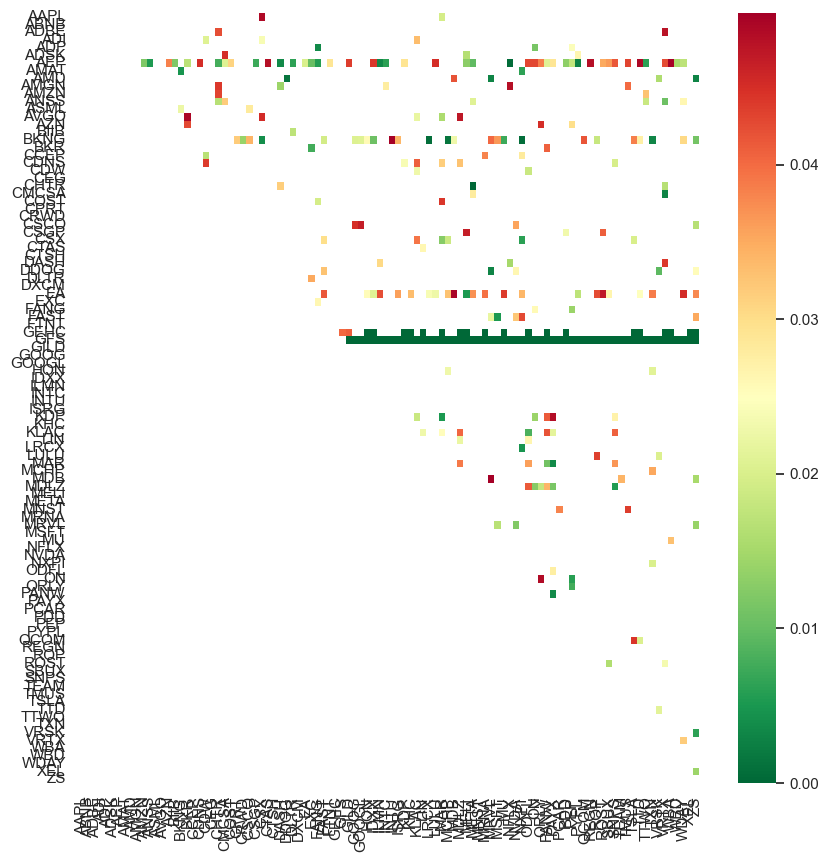

In [7]:
# Assuming you have a function called dickey_fuller_test for ADF test
passing_pairs = []
scores, pvalues, pairs = find_cointegrated_pairs(df)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap of p-values with a mask for the upper triangle
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(pvalues, xticklabels=df.columns, yticklabels=df.columns, cmap='RdYlGn_r', mask=(pvalues >= 0.05))

print("Cointegrated pairs:", pairs)

for stock1, stock2 in pairs:
    # Run the ADF test for both stocks in the pair
    if dickey_fuller_test(df[stock1]) and dickey_fuller_test(df[stock2]):
        passing_pairs.append((stock1, stock2))

# Output the passing pairs
print("ADF & Coint Passing pairs:", passing_pairs)


In [8]:
df['IBM'].plot()
df['MSFT'].plot()

KeyError: 'IBM'

# Tarde Algorithm 

In [ ]:
def trade(S1, S2, window1, window2, initial_capital=10000):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0, [], []  # Return empty lists for pnl and invested capital

    # Compute rolling mean and rolling standard deviation
    ratios = S1 / S2
    ma1 = ratios.rolling(window=window1, center=False).mean()
    ma2 = ratios.rolling(window=window2, center=False).mean()
    std = ratios.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2) / std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    
    pnl = []  # To track PnL over time
    cash = []
    pf_value= []
    for i in range(len(ratios)):
        # Calculate total invested capital
        total_invested = S1[i] * abs(countS1) + S2[i] * abs(countS2)
        available_capital= initial_capital - total_invested + money
        cash.append(available_capital)
        pf_value.append(initial_capital + money)
        
        # Sell short if the z-score is > 1
        if zscore[i] < -1 and available_capital >0:
            money += S1[i] - S2[i] * ratios[i]
            if available_capital > abs(money):
                countS1 -= 1
                countS2 += ratios[i]
        # Buy long if the z-score is < -1
        elif zscore[i] > 1 and available_capital > 0:
            money -= S1[i] - S2[i] * ratios[i]
            if available_capital > abs(money):
                countS1 += 1
                countS2 -= ratios[i]
                
        #Exit positions
        # Clear positions if the z-score is between -0.5 and 0.5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
        
        pnl.append(money)  # Record PnL at this time step
    
    return money, pnl, cash, pf_value

In [ ]:
start = datetime.datetime(2023, 1, 1)
end = datetime.datetime(2024, 6, 1)

# Extract unique tickers from passing_pairs
tickers = set([stock for pair in passing_pairs for stock in pair])

# Download data for the passing pairs' tickers
df = pdr.get_data_yahoo(list(tickers), start, end)['Close']


In [ ]:
# Define the starting index as a variable
start_index = 0

# Initialize a variable to accumulate the total sum of final_money
total_money = []

# Loop through each passing pair and call the trade function
for stock1, stock2 in passing_pairs:    
    # Call the trade function for each pair using the stock symbols dynamically
    final_money, pnl_over_time, cash, pf_value = trade(
        df[stock1].iloc[start_index:],  # Dynamically select the first stock
        df[stock2].iloc[start_index:],  # Dynamically select the second stock
        60,  # Example parameter
        5    # Example parameter
    )
    
    # Accumulate the final money
    total_money.append(final_money)
    
    # Print the results for each pair
    print(f"Final Money for {stock1} and {stock2}: {final_money}")


total_money = np.array(total_money)
# Print the total sum of money
print(f"Total sum of money across all pairs: {total_money.sum()}")
print(total_money.min())
print(total_money.max())


In [ ]:

zscore(df['AEP']).plot()
zscore(df['LULU']).plot()
plt.show()

zscore(df['BKNG']).plot()
zscore(df['TTD']).plot()
plt.show()




In [ ]:
dates = df.index[start_index:]
def plots():
    
    # Plotting
    plt.figure(figsize=(14, 7))
    plt.plot(dates, pnl_over_time, label='PnL Over Time', color='blue')
    plt.axhline(0, color='red', linestyle='--', label='Zero PnL Line')
    plt.title('Profit and Loss Over Time')
    plt.xlabel('Date')
    plt.ylabel('PnL')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plotting
    plt.figure(figsize=(14, 7))
    plt.plot(dates, pf_value, label='PnL Over Time', color='blue')
    plt.title('Portfolio Value')
    plt.xlabel('Date')
    plt.ylabel('PF Value')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.plot(dates,cash, label='Invested Capital', color='blue')
    plt.title('Available Cash Over Time')
    plt.xlabel('Time')
    plt.ylabel('Cash')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.show()
plots()